#### Read-in the data

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [54]:
def read_clean_data(filename):
    df = pd.read_csv(filename)[['title','artist','year','bpm', 'nrgy', 'dnce', 'dB','live', 'val', 'dur','acous', 'spch','pop']]
    df = df.rename({'bpm':'tempo','nrgy':'energy','dnce':'danceability','dB':'loudness','live':'liveness',
                  'val':'valence','dur':'duration','acous':'acousticness','spch':'speechiness','pop':'popularity'},
                 axis = 1)
    df['decade'] = filename[2:4] + 's'
    return df

In [55]:
from sklearn.preprocessing import StandardScaler

filenames = ['1950.csv','1980.csv','2010.csv']

df = pd.concat([read_clean_data(i) for i in filenames]).reset_index()
df_id = df[["title","artist","decade"]]
df = df.iloc[:,4:len(df.columns)-1]

# pozymiai, pagal kuriuos klasteriuojama
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
tempo,118.201439,25.296846,62.0,100.00,117.0,135.00,195.0
energy,58.125899,22.835987,6.0,41.25,60.5,78.75,98.0
danceability,60.435252,14.348717,18.0,51.00,62.0,71.00,93.0
loudness,-8.460432,3.952363,-18.0,-11.00,-8.0,-5.00,-2.0
liveness,17.417266,13.359186,2.0,9.00,13.0,22.00,82.0
valence,55.636691,25.027949,9.0,34.00,55.0,77.75,99.0
duration,212.309353,56.488566,98.0,174.25,210.0,245.00,433.0
acousticness,33.744604,31.073156,0.0,7.00,20.5,61.00,100.0
speechiness,5.805755,5.445997,2.0,3.00,4.0,6.00,46.0
popularity,63.629496,16.622897,26.0,54.00,68.0,76.00,94.0


In [56]:
# standarizuojama
x = StandardScaler().fit_transform(df)

In [4]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

def do_mds(x,n_components=2,**kwargs): 
    mds = MDS(n_components,**kwargs)
    x_trans = mds.fit_transform(x)
    
    return x_trans


def do_pca(x,n_components=2,**kwargs): 
    pca = PCA(n_components,**kwargs)
    x_trans = pca.fit_transform(x)
    
    return x_trans

# klasterizavimas originaliems duomenims ir sumazinus dimensija
x_small = do_pca(x,n_components=2)

df_plot = pd.DataFrame(do_pca(x))
df_plot.columns = ["x","y"]

In [5]:
# x -> originalios dimensijos duomenys
# x_small -> sumazintos dimensijos (dim=2) duomenys

# (abu standartizuoti)
# tikslas - palyginti ar gaunami tokie patys rezultatai su abiem duomenu aibemis

# df_plot -> sumazinta dimensija Vizualizavimui -> skirta pagal gautus rezultatus prideti stulpeli "cluster" ir pavaizduoti

Text(0.5, 1.0, 'Songs by decade (reduced dimensionality data)')

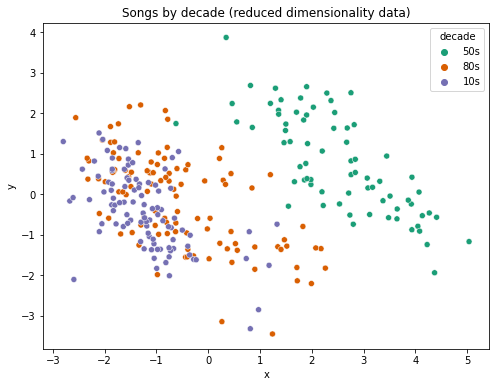

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
plot = sns.scatterplot(x="x",y="y",hue=df_id["decade"],data=df_plot,palette="Dark2",ax=ax)
plot.set_title("Songs by decade (reduced dimensionality data)")

#### KMeans

In [7]:
def do_kmeans(x, standartize = True,**kwargs):  
    
    model = KMeans(**kwargs)
    pred = model.fit_predict(x)

    return pred, model

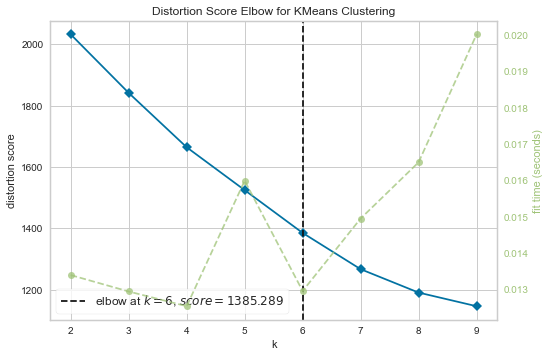

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(), k=(2,10))

visualizer.fit(x)        
visualizer.show()           

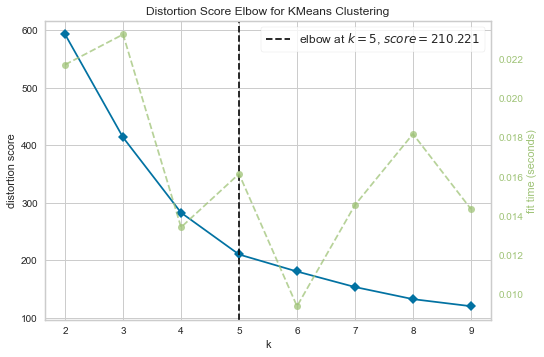

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
visualizer = KElbowVisualizer(KMeans(), k=(2,10))

visualizer.fit(x_small)        
visualizer.show()      

Text(0, 0.5, 'Average silhouette width')

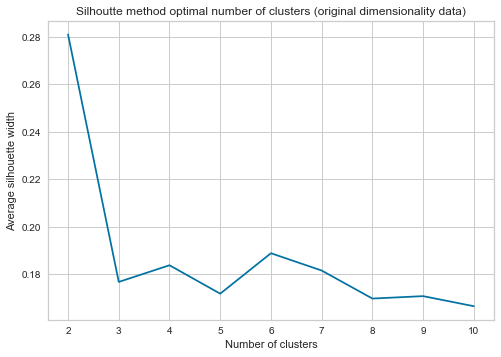

In [10]:
silhouette_scores = []
for i in list(range(2,11)):
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(x)  
    silhouette_scores.append(visualizer.silhouette_score_)
    
plt.clf()
plt.plot(range(2,11),silhouette_scores)
plt.title("Silhoutte method optimal number of clusters (original dimensionality data)")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette width")

Text(0, 0.5, 'Average silhouette width')

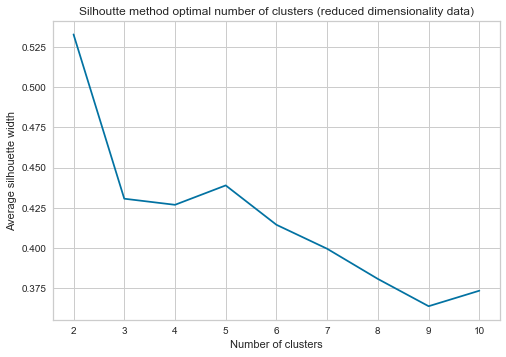

In [11]:
silhouette_scores = []
for i in list(range(2,11)):
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(x_small)  
    silhouette_scores.append(visualizer.silhouette_score_)
    
plt.clf()
plt.plot(range(2,11),silhouette_scores)
plt.title("Silhoutte method optimal number of clusters (reduced dimensionality data)")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette width")

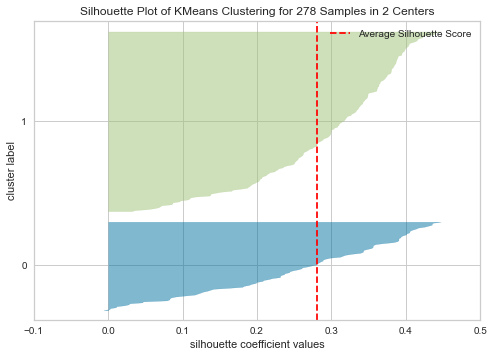

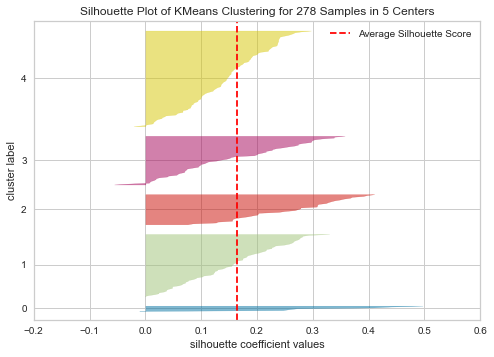

In [12]:
for i in [2,5]:
    model = KMeans(i,random_state=123)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(x)        
    visualizer.show()       

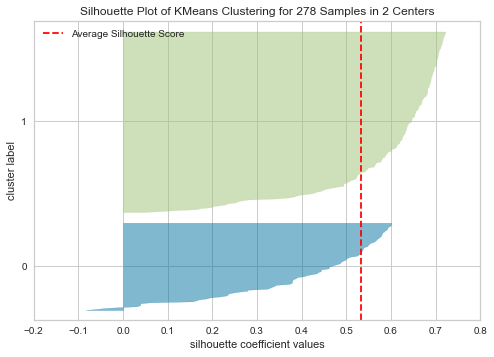

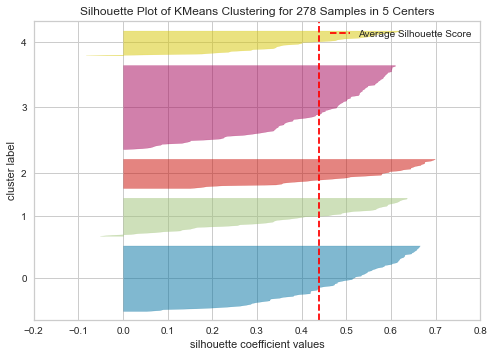

In [13]:
for i in [2,5]:
    model = KMeans(i,random_state=123)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(x_small)        
    visualizer.show()       

Text(0.5, 1.0, 'K-means clustering (reduced dimensionality data)')

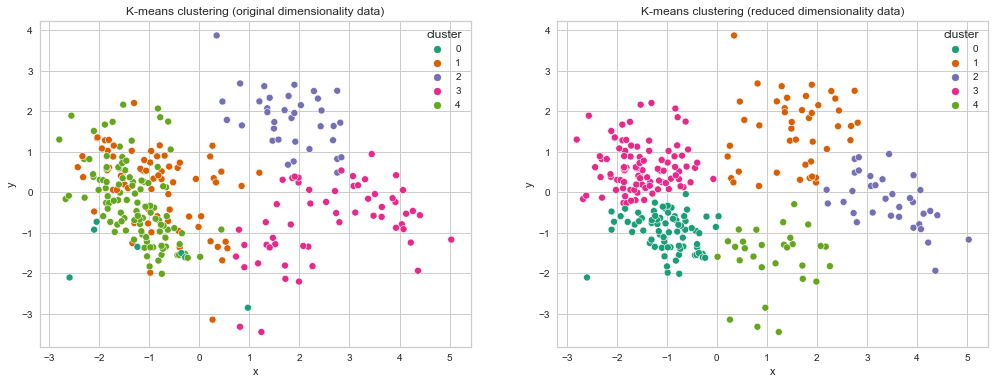

In [15]:
# elbow metodas
fig, ax = plt.subplots(1,2,figsize=(17, 6))
ax = ax.flatten()
df_plot["cluster"], _ = do_kmeans(x,n_clusters=5,random_state=123)
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[0])
plot.set_title("K-means clustering (original dimensionality data)")

df_plot["cluster"], _ = do_kmeans(x_small,n_clusters=5,random_state=123)
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[1])
plot.set_title("K-means clustering (reduced dimensionality data)")

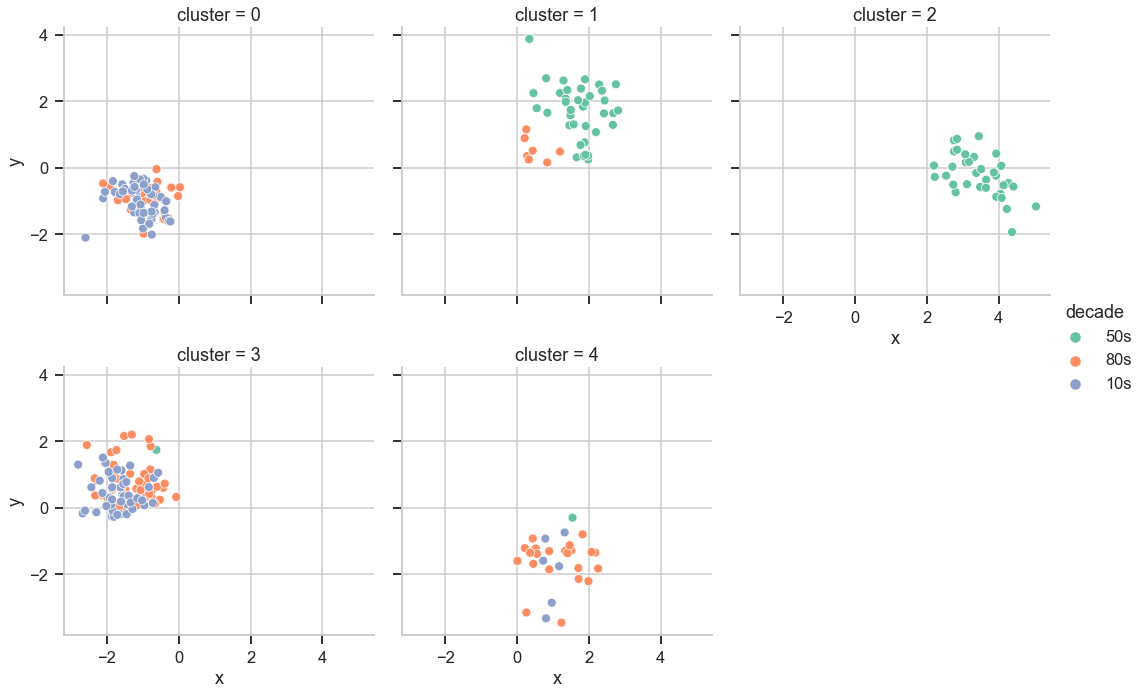

In [16]:
# kuo skiriasi klasteriai pagal desimtmecius
sns.set_context("talk")
df_plot["decade"] = df_id["decade"]
sns.relplot(x="x",y="y",kind="scatter",data=df_plot,col="cluster",hue="decade",palette="Set2",col_wrap=3)

Text(0.5, 1.0, 'K-means clustering (reduced dimensionality data)')

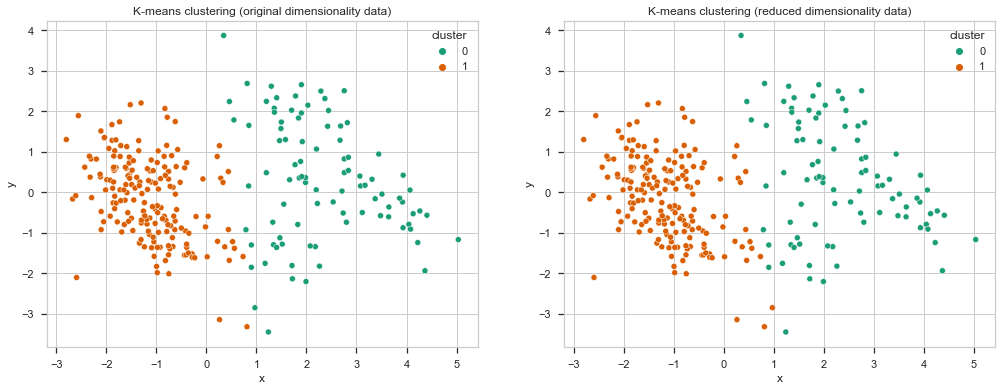

In [17]:
# silhouette metodas
sns.set_context("notebook")
fig, ax = plt.subplots(1,2,figsize=(17, 6))
ax = ax.flatten()
df_plot["cluster"], _ = do_kmeans(x,n_clusters=2,random_state=123)
df["cluster_original"] = df_plot["cluster"]
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[0])
plot.set_title("K-means clustering (original dimensionality data)")


df_plot["cluster"], _ = do_kmeans(x_small,n_clusters=2,random_state=123)
df["cluster_reduced"] = df_plot["cluster"]
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[1])
plot.set_title("K-means clustering (reduced dimensionality data)")

In [19]:
def statistics(df):
    statistics_1 = df.groupby("cluster_original").describe().T
    statistics_1 = statistics_1.reset_index()[statistics_1.reset_index()["level_1"].isin(["mean"])]
    columns = list(statistics_1.columns)
    columns[0] = "variable"
    columns[1] = "statistic"
    for i in range(2,len(columns)):
        columns[i] = str(columns[i]) + "_original"
    statistics_1.columns = columns
    
    statistics_2 = df.groupby("cluster_reduced").describe().T
    statistics_2 = statistics_2.reset_index()[statistics_2.reset_index()["level_1"].isin(["mean"])]
    columns = list(statistics_2.columns)
    columns[0] = "variable"
    columns[1] = "statistic"
    for i in range(2,len(columns)):
        columns[i] = str(columns[i]) + "_reduced"
    statistics_2.columns = columns

    statistics =  statistics_1.merge(statistics_2,how="inner")
    
    statistics = statistics.reindex(sorted(statistics.columns), axis=1)
    
    return statistics

In [20]:
# klasteriu palyginimas
print(df["cluster_original"].value_counts())
print(df["cluster_reduced"].value_counts())

statistics(df)

1    186
0     92
Name: cluster_original, dtype: int64
1    187
0     91
Name: cluster_reduced, dtype: int64


,0_original,0_reduced,1_original,1_reduced,statistic,variable
0,113.195652,113.417582,120.677419,120.529412,mean,tempo
1,34.010870,34.076923,70.053763,69.828877,mean,energy
2,51.239130,51.263736,64.983871,64.898396,mean,danceability
3,-11.989130,-11.978022,-6.715054,-6.748663,mean,loudness
4,16.663043,16.736264,17.790323,17.748663,mean,liveness
5,51.956522,52.329670,57.456989,57.245989,mean,valence
6,170.923913,170.043956,232.779570,232.877005,mean,duration
7,70.597826,70.615385,15.516129,15.802139,mean,acousticness
8,4.304348,4.021978,6.548387,6.673797,mean,speechiness
9,46.934783,46.560440,71.887097,71.935829,mean,popularity


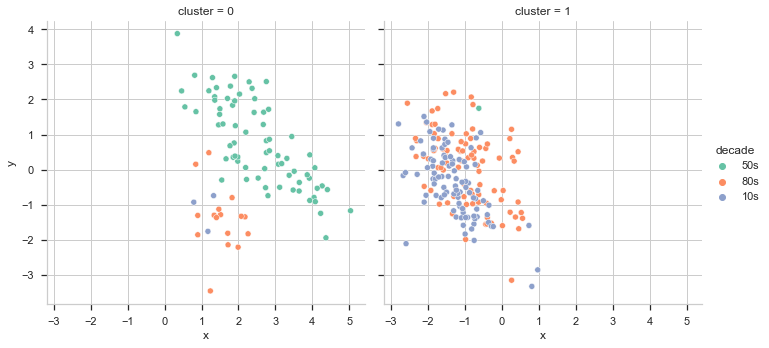

In [21]:
# kuo skiriasi klasteriai pagal desimtmecius
df_plot["decade"] = df_id["decade"]
sns.relplot(x="x",y="y",kind="scatter",data=df_plot,col="cluster",hue="decade",palette="Set2")

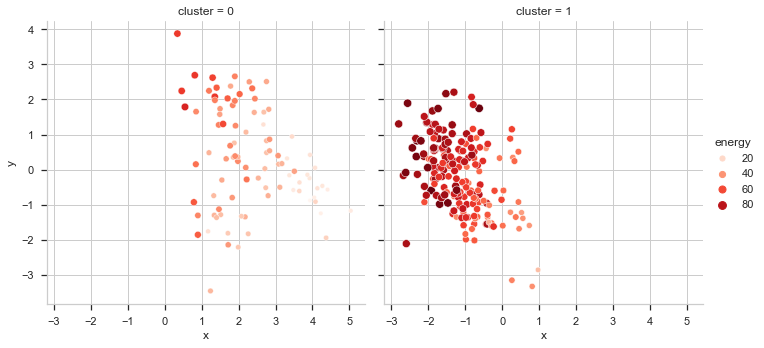

In [22]:
df_plot["energy"] = df["energy"]
sns.relplot(x="x",y="y",kind="scatter",hue="energy",size="energy",data=df_plot,col="cluster",palette="Reds")

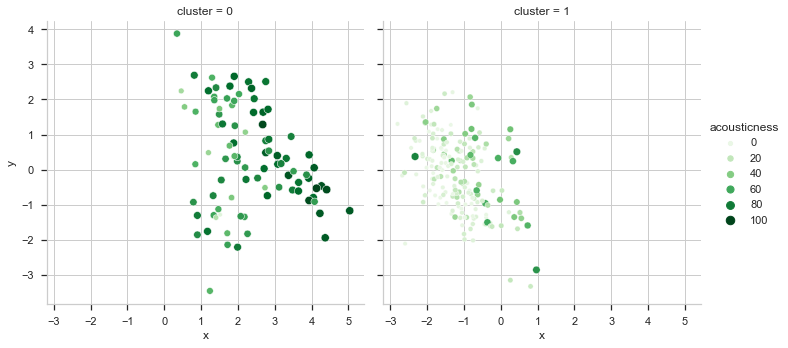

In [25]:
df_plot["acousticness"] = df["acousticness"]
sns.relplot(x="x",y="y",kind="scatter",hue="acousticness",size="acousticness",data=df_plot,col="cluster",palette="Greens",
            hue_norm = (-10,100))

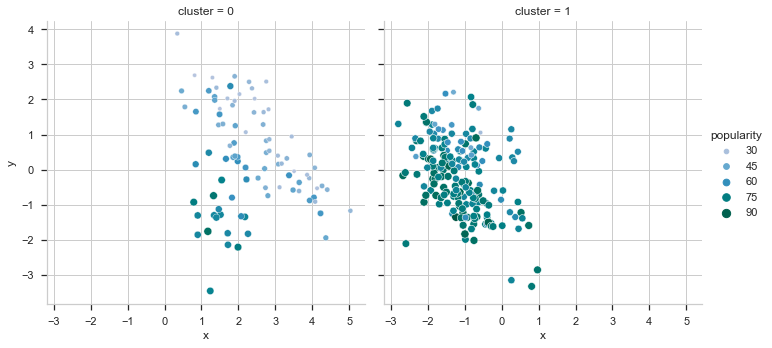

In [26]:
df_plot["popularity"] = df["popularity"]
sns.relplot(x="x",y="y",kind="scatter",hue="popularity",size="popularity",data=df_plot,col="cluster",palette="PuBuGn",
            hue_norm = (-10,100))

#### Hierarchical

In [130]:
def do_hierarchical(df, standartize = True,**kwargs):  
    model =  AgglomerativeClustering(**kwargs)
    pred = model.fit_predict(x)

    return pred, model

In [131]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    fig, ax = plt.subplots(1,1,figsize=(17, 6))
    dendrogram(linkage_matrix, **kwargs, ax = ax)


Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram Ward linkage')

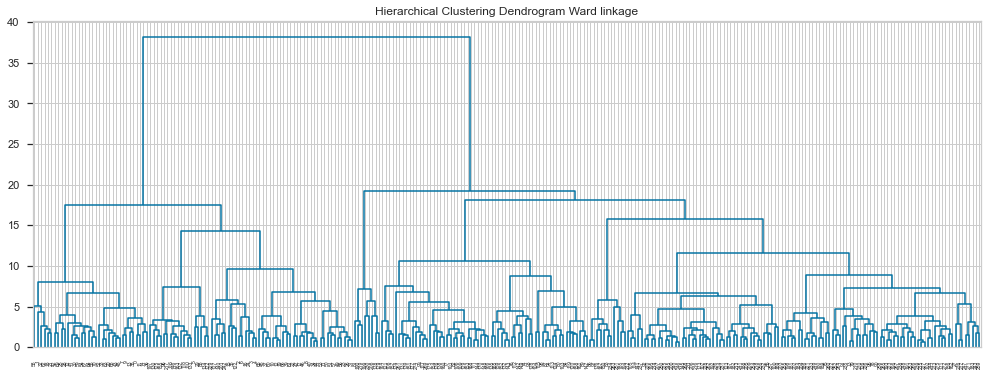

In [132]:
_, model = do_hierarchical(x,distance_threshold=0, n_clusters=None,linkage="ward")


plot_dendrogram(model, color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram Ward linkage")

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram Ward linkage')

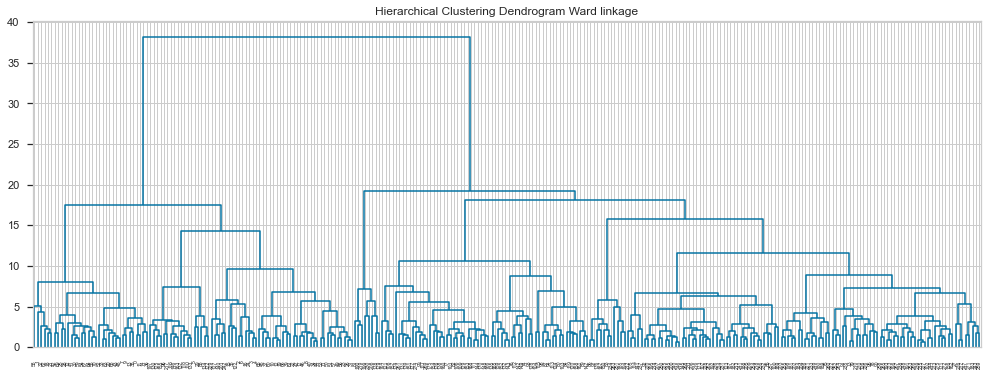

In [133]:
_, model = do_hierarchical(x_small,distance_threshold=0, n_clusters=None,linkage="ward")


plot_dendrogram(model, color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram Ward linkage")

Text(0.5, 1.0, 'Hierarchical clustering (reduced dimensionality data)')

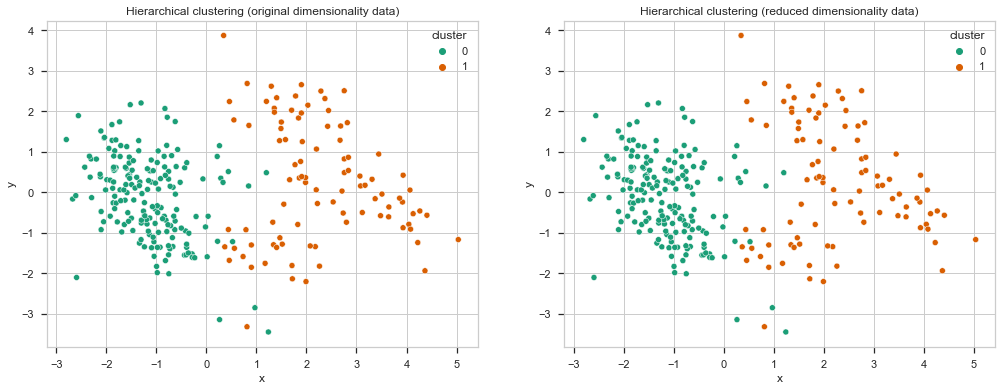

In [134]:
fig, ax = plt.subplots(1,2,figsize=(17, 6))
ax = ax.flatten()
df_plot["cluster"], _ = do_hierarchical(x,n_clusters=2,linkage="ward")
df["cluster_original"] = df_plot["cluster"]
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[0])
plot.set_title("Hierarchical clustering (original dimensionality data)")

df_plot["cluster"], _ = do_hierarchical(x_small,n_clusters=2,linkage="ward")
df["cluster_reduced"] = df_plot["cluster"]
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[1])
plot.set_title("Hierarchical clustering (reduced dimensionality data)")

In [135]:
print(df["cluster_original"].value_counts())
print(df["cluster_reduced"].value_counts())

statistics(df)

0    184
1     94
Name: cluster_original, dtype: int64
0    184
1     94
Name: cluster_reduced, dtype: int64


,0_original,0_reduced,1_original,1_reduced,statistic,variable
0,120.119565,120.119565,114.446809,114.446809,mean,tempo
1,70.146739,70.146739,34.595745,34.595745,mean,energy
2,65.331522,65.331522,50.851064,50.851064,mean,danceability
3,-6.771739,-6.771739,-11.765957,-11.765957,mean,loudness
4,17.826087,17.826087,16.617021,16.617021,mean,liveness
5,58.250000,58.250000,50.521277,50.521277,mean,valence
6,232.815217,232.815217,172.170213,172.170213,mean,duration
7,15.684783,15.684783,69.095745,69.095745,mean,acousticness
8,6.760870,6.760870,3.936170,3.936170,mean,speechiness
9,71.820652,71.820652,47.595745,47.595745,mean,popularity


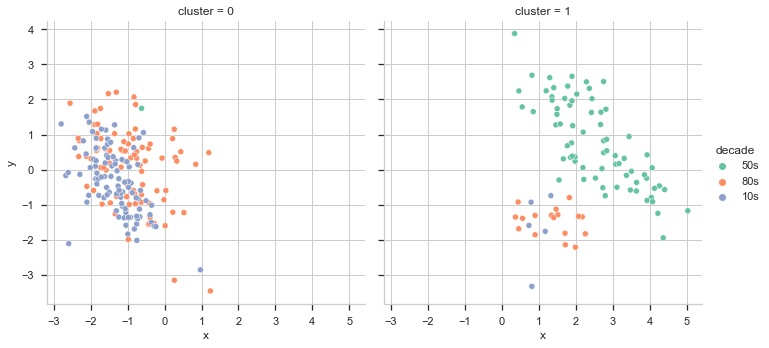

In [136]:
df_plot["decade"] = df_id["decade"]
sns.relplot(x="x",y="y",kind="scatter",data=df_plot,col="cluster",hue="decade",palette="Set2")

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram Complete linkage')

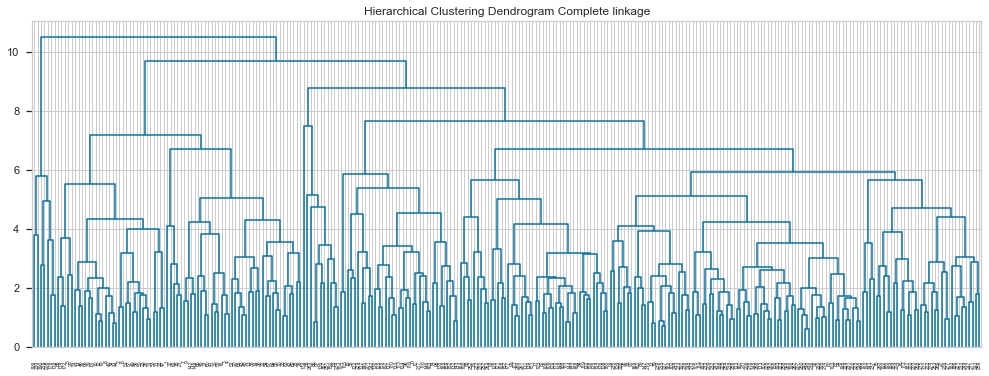

In [137]:
# kitas jungimo metodas
_, model = do_hierarchical(x,distance_threshold=0, n_clusters=None,linkage="complete")


plot_dendrogram(model,color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram Complete linkage")

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram Complete linkage')

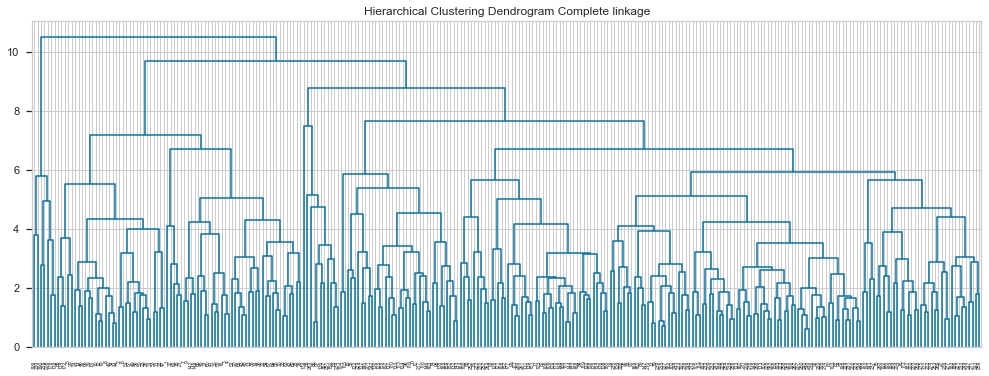

In [138]:
_, model = do_hierarchical(x_small,distance_threshold=0, n_clusters=None,linkage="complete")


plot_dendrogram(model,color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram Complete linkage")

Text(0.5, 1.0, 'Hierarchical clustering (reduced dimensionality data)')

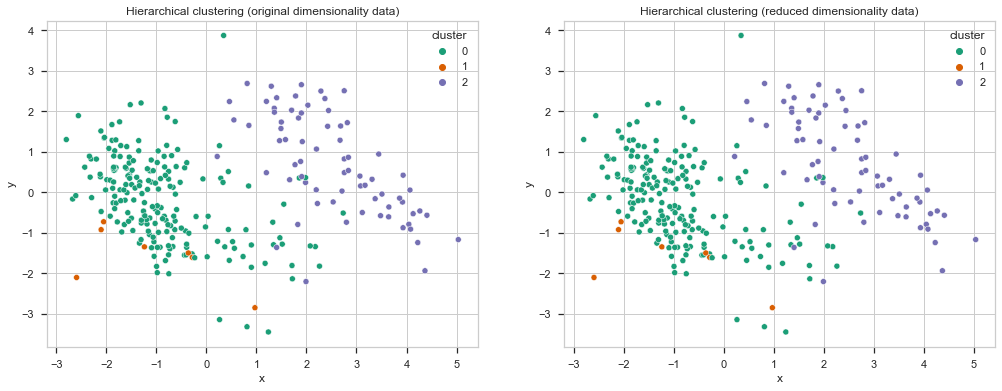

In [139]:
# kazkokie prastesni rezultatai
fig, ax = plt.subplots(1,2,figsize=(17, 6))
ax = ax.flatten()
df_plot["cluster"], _ = do_hierarchical(x,n_clusters=3,linkage="complete")
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[0])
plot.set_title("Hierarchical clustering (original dimensionality data)")

df_plot["cluster"], _ = do_hierarchical(x_small,n_clusters=3,linkage="complete")
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot,palette="Dark2",ax=ax[1])
plot.set_title("Hierarchical clustering (reduced dimensionality data)")

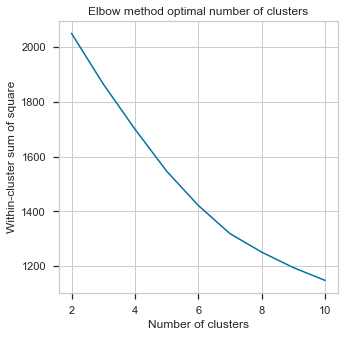

In [121]:
# jeigu kazkur prireiktu
distortion = []
for k in range(2, 11):
    variance = []
    model =  AgglomerativeClustering(n_clusters=k,linkage="ward")
    clusters = model.fit_predict(x)
    x_df = pd.DataFrame(x)
    for i in np.unique(clusters):
        variance.append(np.linalg.norm((x_df[clusters == i] - x_df[clusters == i].mean()))**2)
    distortion.append(np.sum(variance))

fig, ax = plt.subplots(1,1,figsize=(5, 5))   
plt.plot(range(2,11),distortion)
plt.title("Elbow method optimal number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster sum of square")
plt.show()

#### DBSCAN

In [76]:
from sklearn.neighbors import NearestNeighbors
def do_dbscan(df, **kwargs): 
    model = DBSCAN(**kwargs)
    pred = model.fit_predict(x)

    return pred, model

In [99]:
x.shape, x_small.shape

((278, 10), (278, 2))

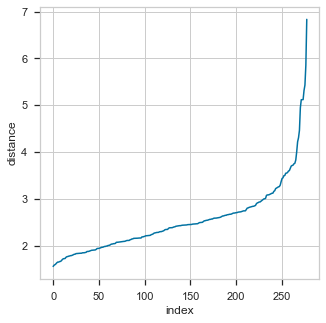

In [120]:
nn=NearestNeighbors(n_neighbors=20).fit(x)

distances, indices = nn.kneighbors(x)
farthest = distances[:,-1]

fig, ax = plt.subplots(1,1,figsize=(5, 5))
plt.plot(np.sort(farthest))
plt.xlabel("index")
plt.ylabel("distance")
plt.show()

#####  Originaliam duomenų rinkiniui: minSamples = 2n = 20 , eps = 3.5

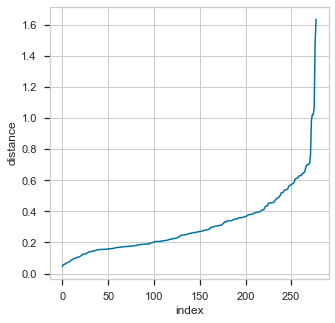

In [119]:
nn=NearestNeighbors(n_neighbors=min_samples_small).fit(x_small)

distances, indices = nn.kneighbors(x_small)
farthest = distances[:,-1]

fig, ax = plt.subplots(1,1,figsize=(5, 5))
plt.plot(np.sort(farthest))
plt.xlabel("index")
plt.ylabel("distance")
plt.show()

#####  Sumažintos dimensijos duomenų rinkiniui: minSamples = 4, eps = 0.7

Text(0.5, 1.0, 'DBSCAN clustering (reduced dimensionality data)')

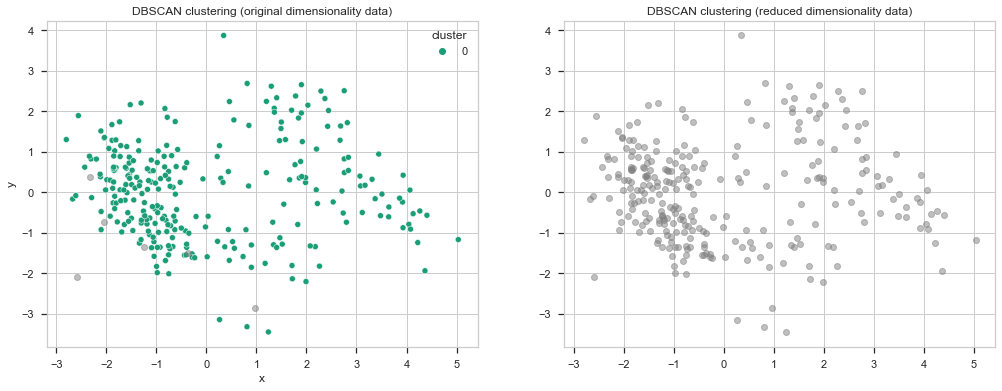

In [80]:
fig, ax = plt.subplots(1,2,figsize=(17, 6))
ax = ax.flatten()
df_plot["cluster"], _ = do_dbscan(x,min_samples=20,eps=3.5)
df_noise = df_plot[df_plot["cluster"]==-1]
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot[df_plot["cluster"]!=-1],palette="Dark2",ax=ax[0])
plot.scatter(df_noise["x"],df_noise["y"],c="grey",alpha=0.5)
plot.set_title("DBSCAN clustering (original dimensionality data)")


df_plot["cluster"], _ = do_dbscan(x_small,min_samples=4,eps=0.7)
df_noise = df_plot[df_plot["cluster"]==-1]
plot = sns.scatterplot(x="x",y="y",hue="cluster",data=df_plot[df_plot["cluster"]!=-1],palette="Dark2",ax=ax[1])
plot.scatter(df_noise["x"],df_noise["y"],c="grey",alpha=0.5)
plot.set_title("DBSCAN clustering (reduced dimensionality data)")